(difference_in_differences)=
# Difference in differences

:::{post} Sept, 2022
:tags: counterfactuals, causal inference, time series, regression, posterior predictive, difference in differences, quasi experiments
:category: beginner
:author: Benjamin T. Vincent
:::

## XXX
Some introduction here

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

from scipy.stats import norm

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Difference in Differences

### Causal DAG

TODO

![](DAG_difference_in_differences.png)

Without `Group` then `Time` is a confounder of the `Treatment` $\rightarrow$ `Outcome` relationship

### Define the difference in differences model

I'm defining this model slightly differently compared to what you might find in other sources. This is to facilitate counterfactual inference later on in the notebook.

$$
\mu_i = \beta_{c} 
        + (\beta_{\Delta} \cdot \mathrm{group}_i)
        + (t_i \cdot \mathrm{trend})
        + (\Delta \cdot \mathrm{treated}_i \cdot \mathrm{group}_i)
$$

where:
* $\mu_i$ is the expected value of the $i^{th}$ observation
* $t$ is time, scaled conveniently so that the pre-intervention measurement time is at $t=0$ and the post-intervention measurement time is $t=1$
* $\mathrm{group}$ is a dummary variable for control ($g=0$) or treatment ($g=1$) group
* $\beta_c$ is the intercept for the control group
* $\beta_{\Delta}$ is a deflection of the treatment group intercept from the control group intercept
* $\mathrm{trend}$ is the slope, and a core assumption of the model is that the slopes are identical for both groups
* $\mathrm{treated}$ is a binary indicator variable for untreated or treated
* $\Delta$ is the causal impact of the treatment

In [3]:
# treated = (t > intervention_time)


def outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group):
    mu = (
        control_intercept
        + (treat_intercept_delta * group)
        + (t * trend)
        + (Δ * (t > intervention_time) * group)
    )
    return mu

### Visualise the difference in differences model

In [4]:
# true parameters
control_intercept = 1
treat_intercept_delta = 0.25
trend = 1
Δ = 1
intervention_time = 0.5

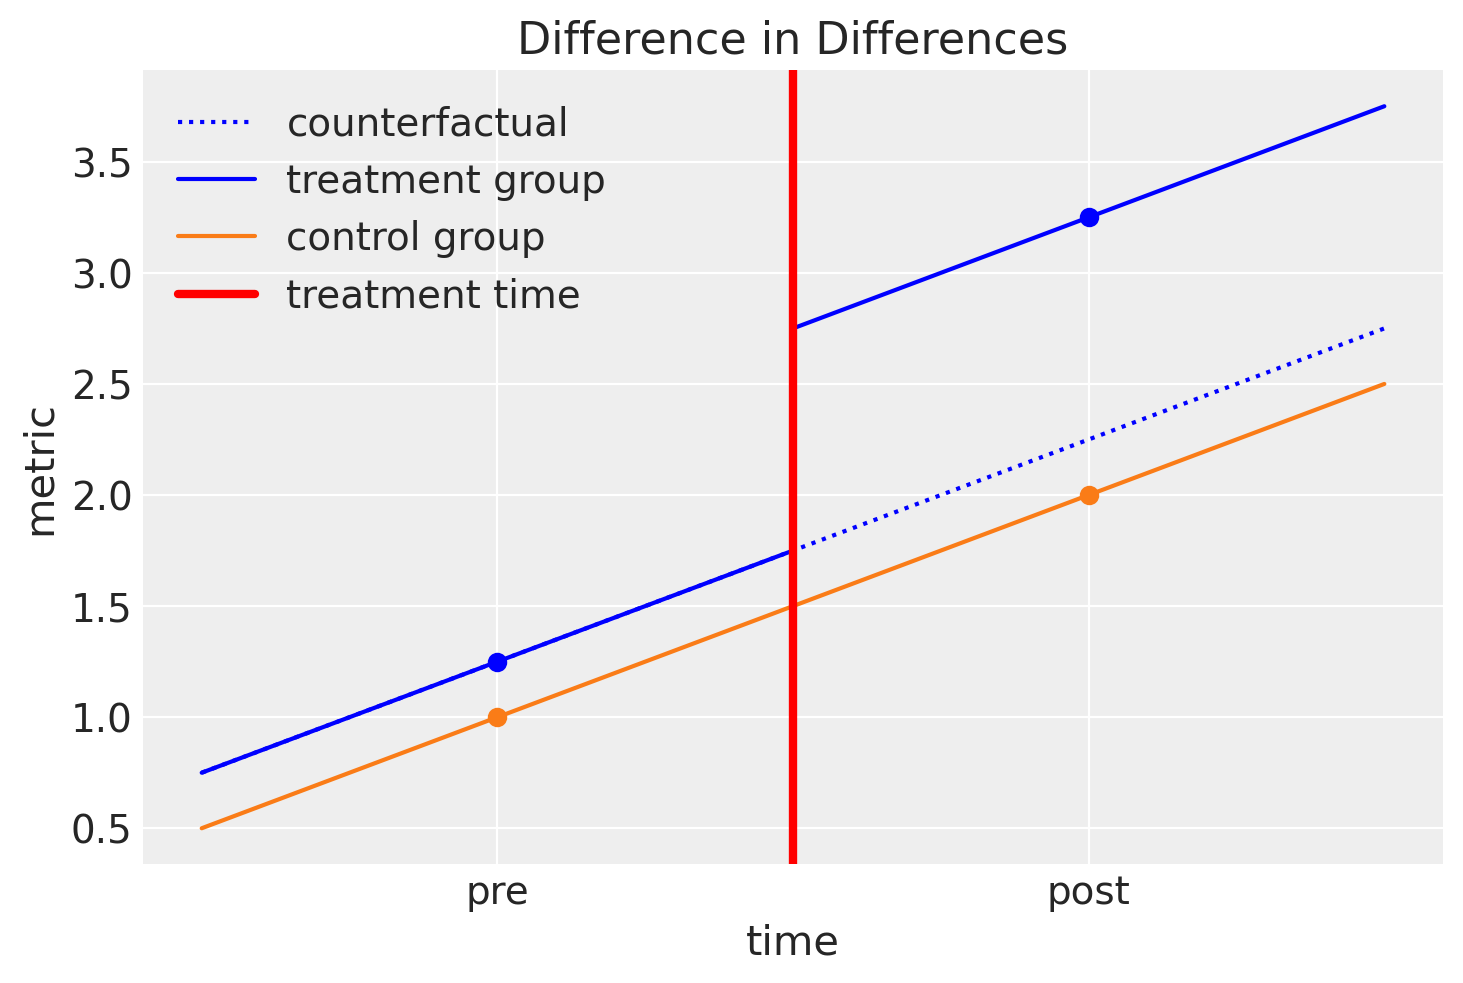

In [5]:
t = np.linspace(-0.5, 1.5, 1000)

# with plt.xkcd():
fig, ax = plt.subplots()
ax.plot(
    t,
    outcome(t, control_intercept, treat_intercept_delta, trend, Δ=0, group=1),
    color="blue",
    label="counterfactual",
    ls=":",
)
ax.plot(
    t,
    outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group=1),
    color="blue",
    label="treatment group",
)
ax.plot(
    t,
    outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group=0),
    color="C1",
    label="control group",
)
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
t = np.array([0, 1])
ax.plot(
    t,
    outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group=1),
    "o",
    color="blue",
)
ax.plot(
    t,
    outcome(t, control_intercept, treat_intercept_delta, trend, Δ=0, group=0),
    "o",
    color="C1",
)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=[0, 1],
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

This is a good point to mention some of the other aspects of the difference in differences approach:
* You want the control and treatment groups to be as similar to each other as possible (i.e. $\beta_\Delta \rightarrow 0$). A large difference in the pre-treatment measures suggests that the groups are _not_ that similar. This opens up the possibility that there are unobserved confounders that could provide an alternative explanation to any treatment effect detected.
* The _parallel trends assumption_ is a major one! if we draw lines through the pre and post treatment outcomes for each group individually then we get 2 slopes. If the slopes are very different, then the _only_ way we can attribute that to a treatment effect is to assume that the slopes (change in groups over time) are identical. Ideally we would be able to measure at multiple time points, but this then turns the approach into more of an interrupted time series design. Without that, you have to carefully examine and justify if the parallel trends assumption is reasonable to make in your case.

## Generate a synthetic dataset

In [6]:
df = pd.DataFrame({"group": [0, 0, 1, 1] * 10, "t": [0.0, 1.0, 0.0, 1.0] * 10})

df["y"] = outcome(df["t"], control_intercept, treat_intercept_delta, trend, Δ, df["group"])
df["y"] += norm(0, 0.1).rvs(df.shape[0])
df.head()

,group,t,y
0,0,0.0,0.919005
1,0,1.0,1.996355
2,1,0.0,1.364930
3,1,1.0,3.163273
4,0,0.0,0.994768


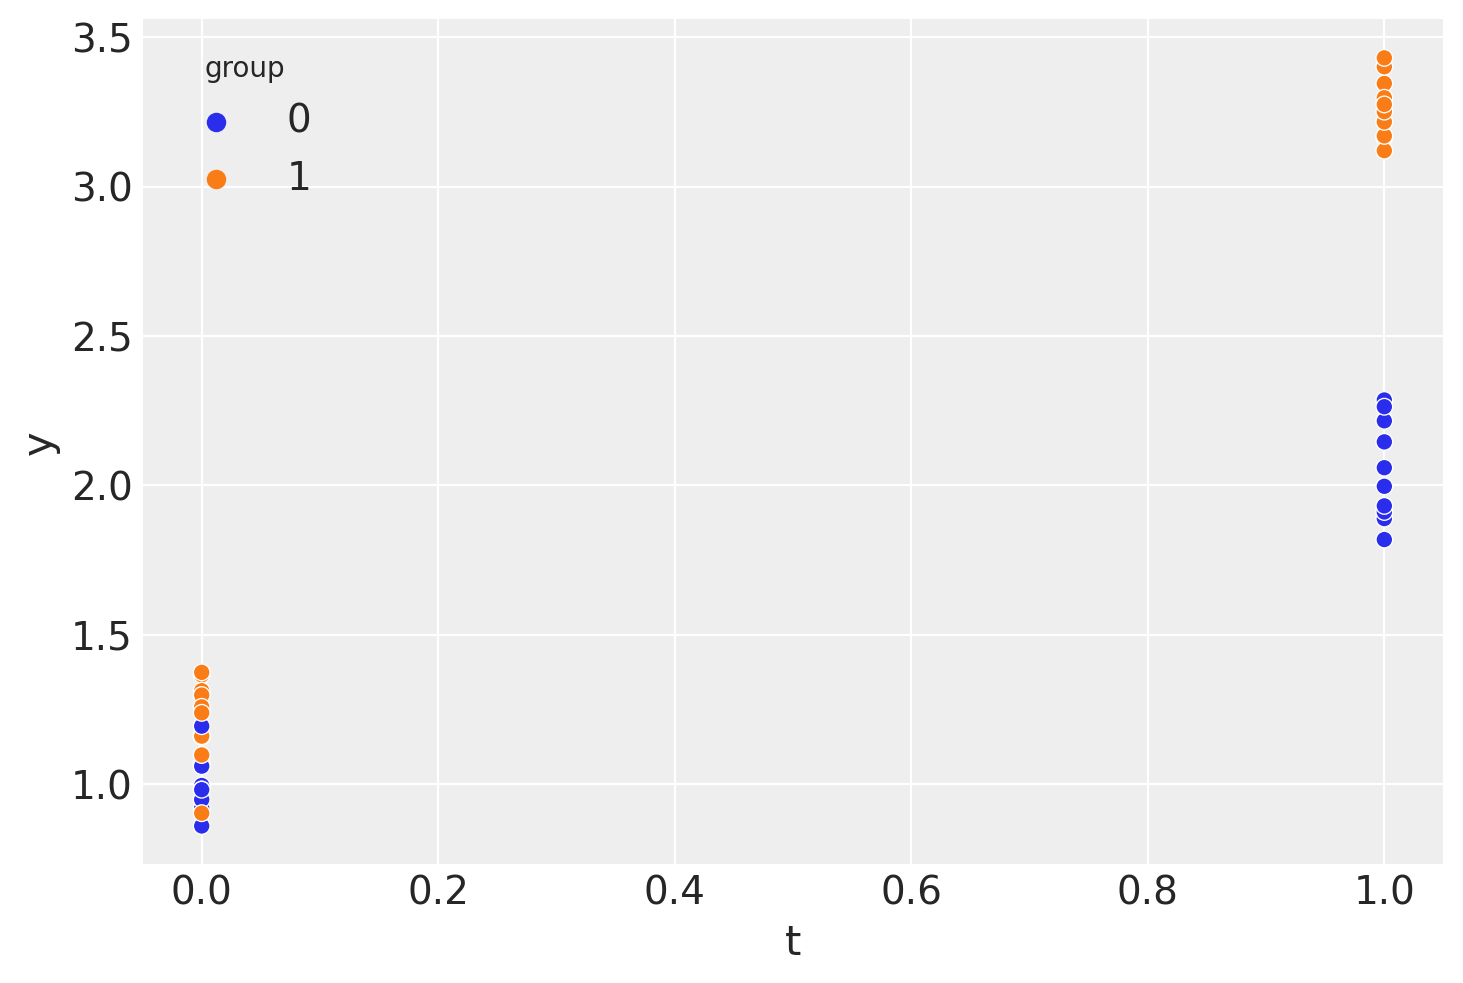

In [7]:
sns.scatterplot(df, x="t", y="y", hue="group");

## Bayesian difference in differences

### PyMC model

In [8]:
with pm.Model() as model:
    # data
    t = pm.MutableData("t", df["t"].values, dims="obs_idx")
    group = pm.MutableData("group", df["group"].values, dims="obs_idx")
    # priors
    _control_intercept = pm.Normal("control_intercept", 0, 5)
    _treat_intercept_delta = pm.Normal("treat_intercept_delta", 0, 1)
    _trend = pm.Normal("trend", 0, 5)
    _Δ = pm.Normal("Δ", 0, 1)
    sigma = pm.HalfNormal("sigma", 1)
    # expectation
    mu = pm.Deterministic(
        "mu",
        outcome(t, _control_intercept, _treat_intercept_delta, _trend, _Δ, group),
        dims="obs_idx",
    )
    # likelihood
    pm.Normal("obs", mu, sigma, observed=df["y"].values, dims="obs_idx")

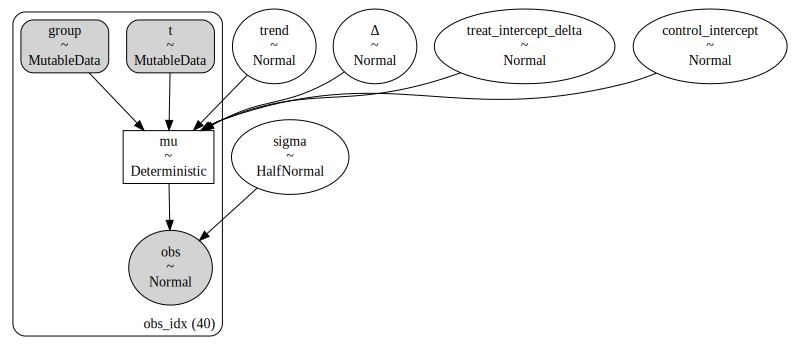

In [9]:
pm.model_to_graphviz(model)

### Inference

In [10]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_intercept, treat_intercept_delta, trend, Δ, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


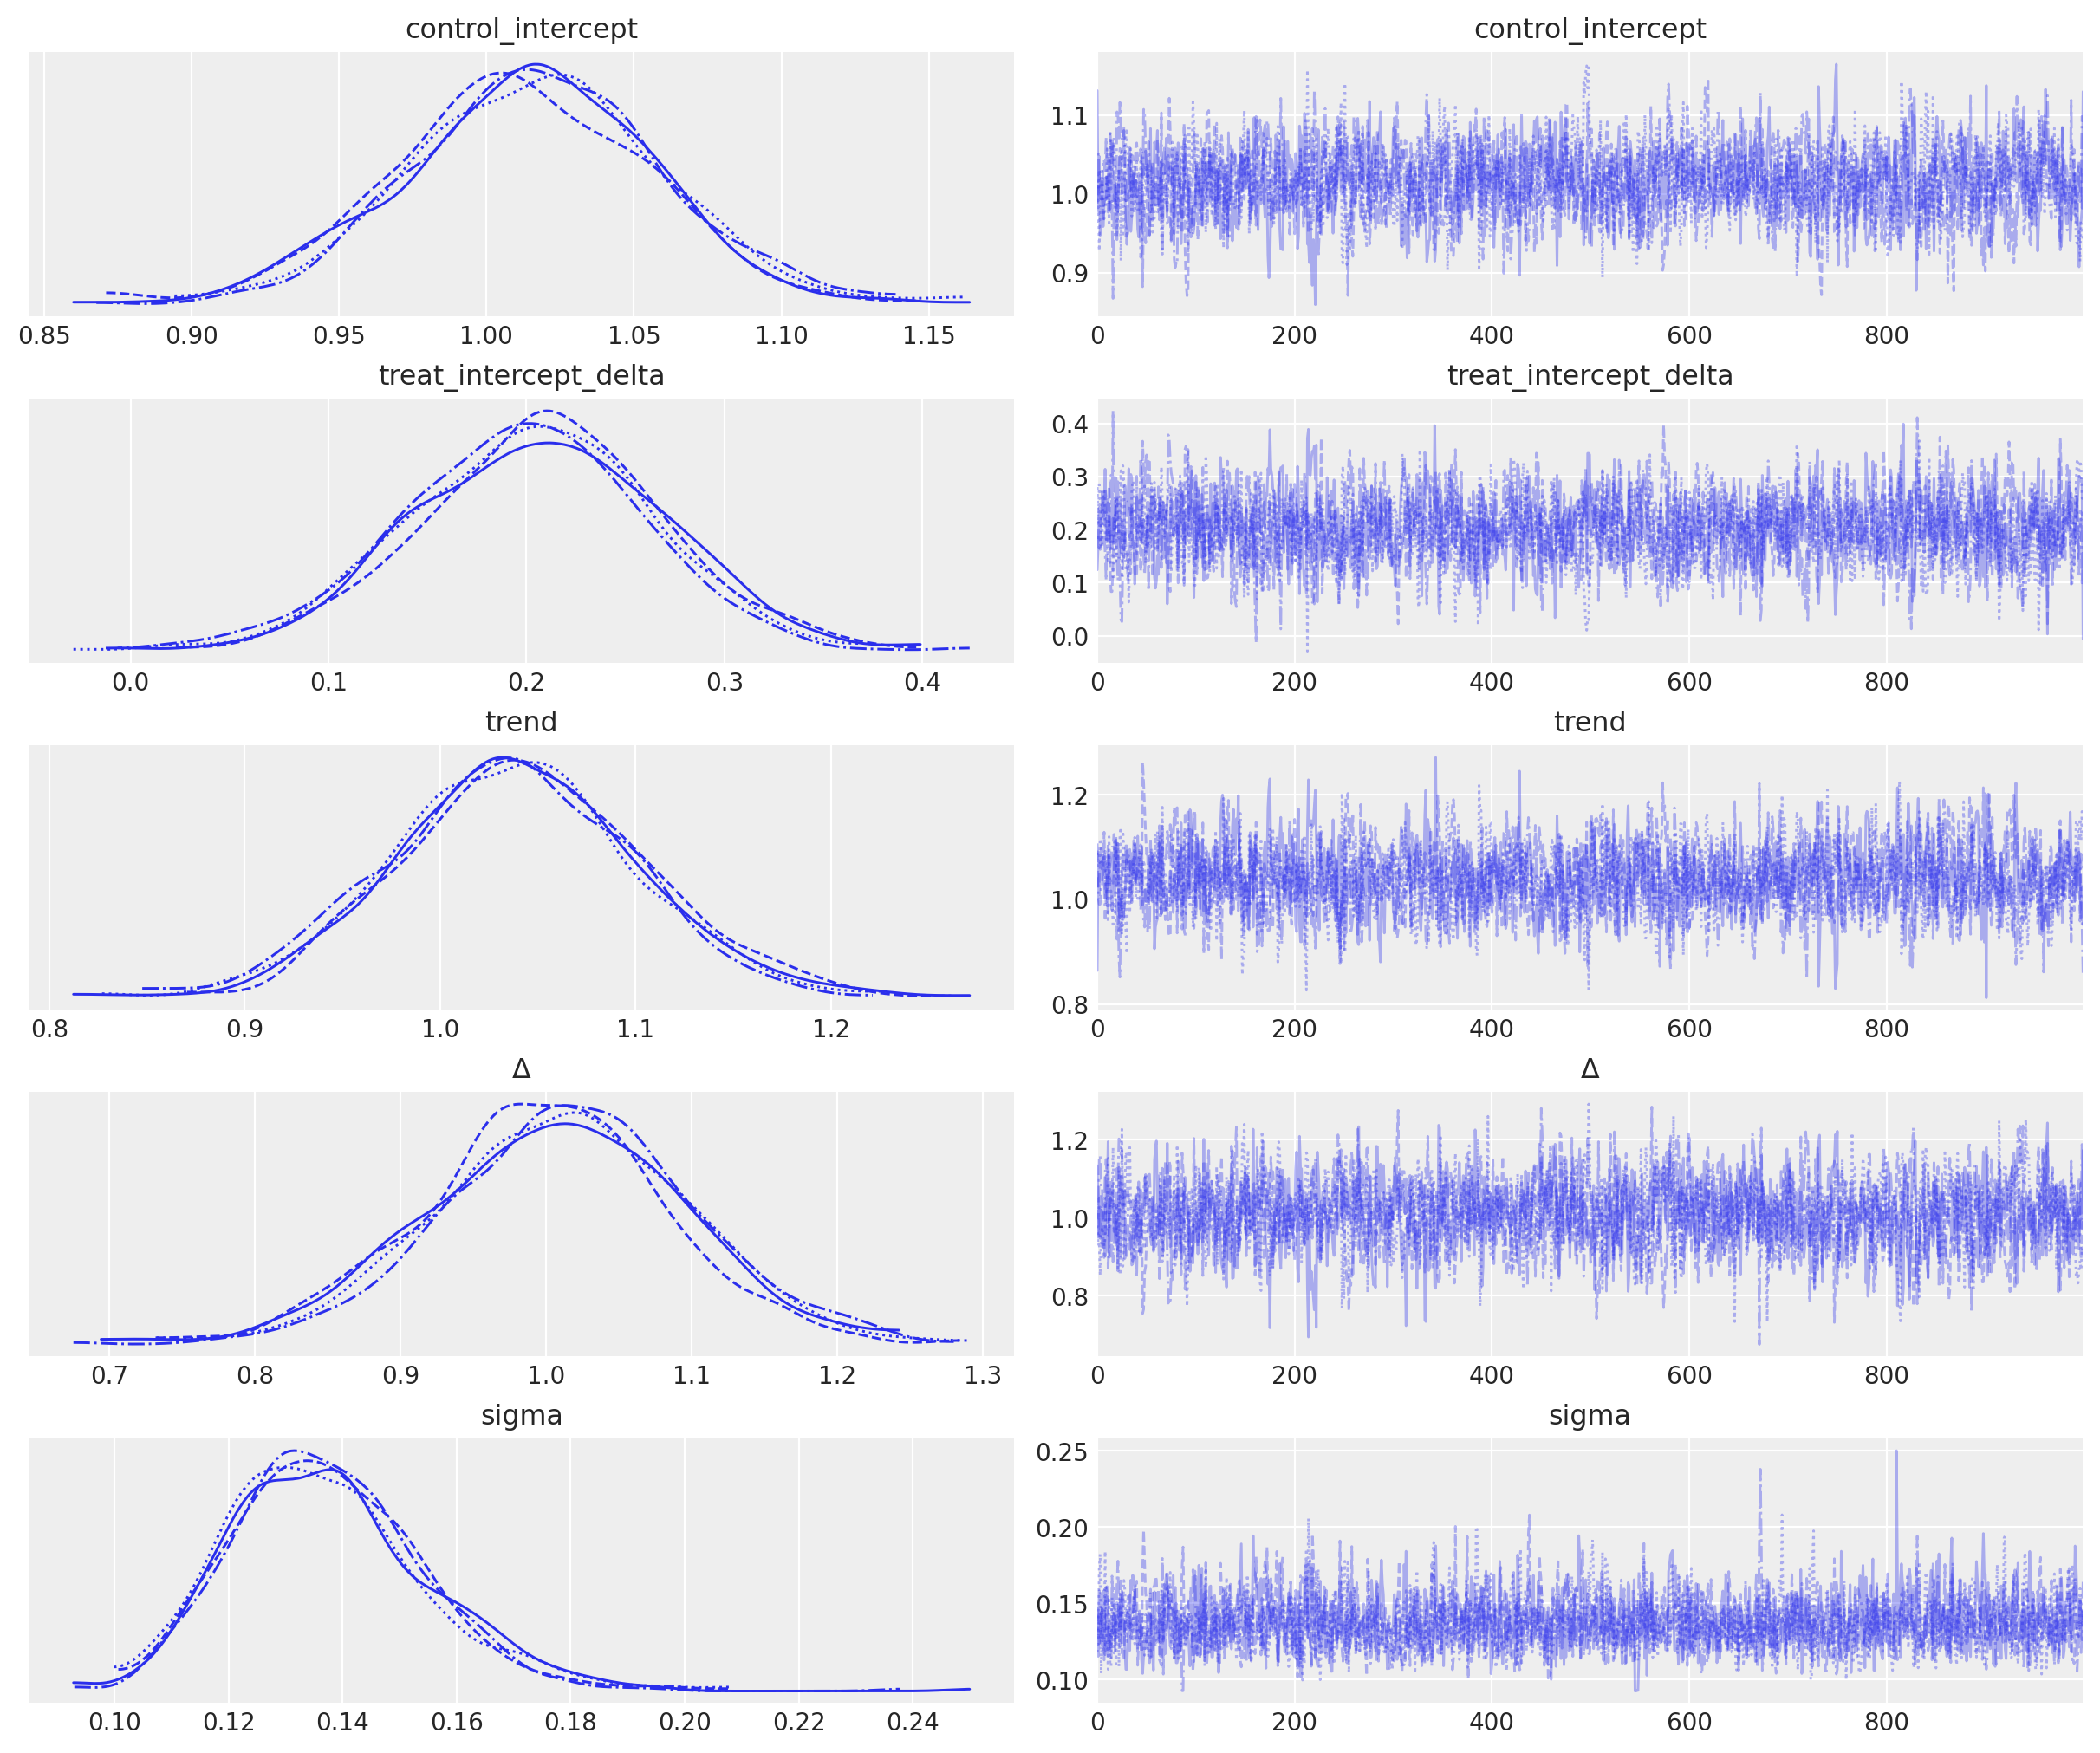

In [11]:
az.plot_trace(idata, var_names="~mu");

## Posterior prediction
NOTE: Technically we are doing 'pushforward prediction' for $\mu$ as this is a deterministic function of it's inputs.

In [12]:
t_control = np.linspace(-0.5, 1.5, 100)

# pushforward predictions for control group
with model:
    group_control = [0] * len(t_control)  # must be integers
    pm.set_data({"t": t_control, "group": group_control})
    ppc_control = pm.sample_posterior_predictive(idata, var_names=["mu"])

# pushforward predictions for treatment group
with model:
    group_treatment = [1] * len(t_control)  # must be integers
    pm.set_data({"t": t_control, "group": group_treatment})
    ppc_treatment = pm.sample_posterior_predictive(idata, var_names=["mu"])

# # counterfactual: what do we predict of the treatment group if they had _not_ been treated
# t_control_counterfactual = np.linspace(0.5, 1.5, 100)  # we want to know about just the post intervention times
# intervention_time = np.infty  # WE DON'T HAVE A DIRECT 'TREATED' VARIABLE, BUT WE CAN IMPLEMENT THAT BY INCREASING THE INTERVENTION TIME TO INFINITY
# with model:
#     group_treatment = [1] * len(t_control_counterfactual)  # must be integers
#     pm.set_data({"t": t_control, "group": group_treatment})
#     ppc_counterfactual = pm.sample_posterior_predictive(idata, var_names=["mu"])

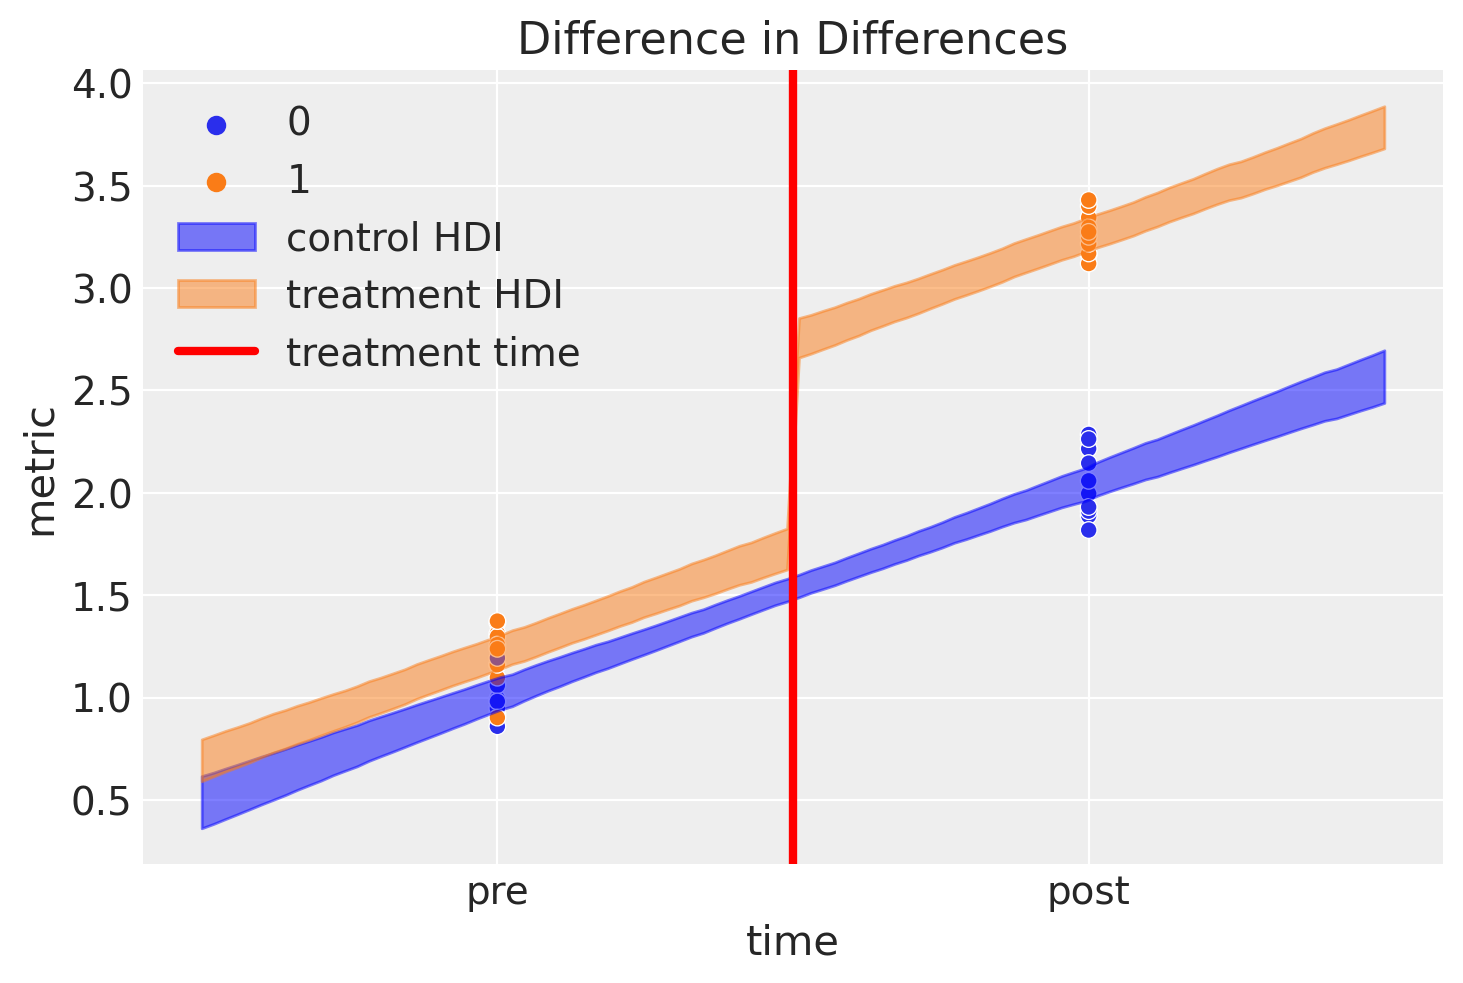

In [13]:
ax = sns.scatterplot(df, x="t", y="y", hue="group")

az.plot_hdi(
    t_control,
    ppc_control.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="blue",
    fill_kwargs={"label": "control HDI"},
)
az.plot_hdi(
    t_control,
    ppc_treatment.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="C1",
    fill_kwargs={"label": "treatment HDI"},
)
# az.plot_hdi(
#     t_control,
#     ppc_counterfactual.posterior_predictive["mu"],
#     smooth=False,
#     ax=ax,
#     color="C2",
#     fill_kwargs={"label": "counterfactual"},
# )
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=[0, 1],
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in Sept 2022.

## Watermark

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Fri Sep 23 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

aesara: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

arviz     : 0.12.1
matplotlib: 3.6.0
pandas    : 1.5.0
numpy     : 1.23.3
pymc      : 4.2.0
aesara    : 2.8.2
seaborn   : 0.12.0
xarray    : 2022.6.0

Watermark: 2.3.1



:::{include} ../page_footer.md
:::